In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
# import keras

# After that, keras.[whatever] is still not necessarily tf! So we need:
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
# from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
# from keras.models import Model, Sequential

import time

tf.__version__, keras.__version__, keras.backend.backend()

('2.2.0-rc3', '2.3.0-tf', 'tensorflow')

In [0]:
if False:
    X_original = np.load('images.npy')
    y_original = np.load('labels.npy')
else:
    from google.colab import drive
    drive.mount('/content/drive')
    X = np.load('/content/drive/My Drive/Colab Notebooks/2020-I/DLNN/Assignment 2/images.npy')
    y = np.load('/content/drive/My Drive/Colab Notebooks/2020-I/DLNN/Assignment 2/labels.npy')


# Normalize X to [0, 1], add color channel
X = X.reshape(*X.shape, 1) / 255.0

# y = 60*y[0]+y[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Multi-class classification setup

In [0]:
# https://keras.io/examples/cifar10_cnn/
# Adapted slightly because otherwise their would be too many outputs that lead to OOM errors

# hour and minute are numbers between 0 and 12 and 0 and 59 respectively (multi-class classification). 
def build_branchCifar1(inputs):

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs) 
    # Added an extra maxpooling layer
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    # Added an extra maxpooling layer
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    
#     Disabled the dense layer
#     x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    hour = Dense(12, activation='softmax', name='hour')(x)
    minute = Dense(59, activation='softmax', name='minute')(x)

    return hour, minute

In [0]:
def buildMC(inputShape, losshr, lossmin, opt, metrics):
    inp = Input(shape=inputShape)
    hourBranch, minuteBranch = build_branchCifar1(inp)
    model = Model(
        inputs=inp,
        outputs=[hourBranch, minuteBranch])
    model.compile(loss=[losshr, lossmin], optimizer=opt, metrics=metrics)
    return model

## Regression setup

In [0]:
# https://keras.io/examples/cifar10_cnn/
# Adapted slightly because otherwise their would be too many outputs that lead to OOM errors

# hour and minute are numbers between 0 and 1 (regression).
def build_branchCifar2(inputs):

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs) 
    # Added an extra maxpooling layer
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    # Added an extra maxpooling layer
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    
#     Disabled the dense layer
#     x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    hour = Dense(1, activation='linear', name='hour')(x)
    minute = Dense(1, activation='linear', name='minute')(x)

    return hour, minute

In [0]:
# ORIGINAL VERSION OF REGRESSION WITH MULTIPLE OUTPUTS

def buildReg(inputShape, losshr, lossmin, opt, metrics):
    inp = Input(shape=inputShape)
    hourBranch, minuteBranch = build_branchCifar2(inp)
    model = Model(
        inputs=inp,
        outputs=[hourBranch, minuteBranch])
    model.compile(loss=[losshr, lossmin], optimizer=opt, metrics=metrics)
    return model

## Specify do-Keras, optimizers, loss function

In [0]:
def do_keras(model, epochs=30, batch_size=256,
             X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val,
             verbose=0, print_other_stuff=True):

    fit_history = model.fit(X_train, [y_train[:,0], y_train[:,1]], epochs=epochs, batch_size=batch_size, validation_data=(X_val, [y_val[:,0], y_val[:,1]]))
    test_score = model.evaluate(X_test, [y_test[:,0], y_test[:,1]], verbose=0)

    if print_other_stuff:
        # print(model.summary())
        pd.DataFrame(fit_history.history).plot(ylim=(0, 2))
        print('** Test loss:', test_score[0])
        print('** Test accuracy:', test_score[1])
    return fit_history, test_score

In [0]:
# Optimizers and loss functions
# https://towardsdatascience.com/a-quick-guide-to-neural-network-optimizers-with-applications-in-keras-e4635dd1cca4
# https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/
# Standard sgd
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
# Can be viewed as a combination of RMSprop and SGD with momentum.
adam = tf.keras.optimizers.Adam(lr=.00001)
# Improvement of adagrad
adadelta = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://towardsdatascience.com/a-guide-to-neural-network-loss-functions-with-applications-in-keras-3a3baa9f71c5
# Loss or multiclass classification
scc = 'sparse_categorical_crossentropy'
# https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/
# Metrics
sca = 'sparse_categorical_accuracy'
acc = 'accuracy'
# Loss for regression
mse = 'mse'

This error function was used in the original experimentation, most likely does not function as well as I initially thought it did. The NP version works (see below), however, this function does not take the tensor input into account and might not be dealing with that properly. 

In [0]:
# Error based on time (so that 12.01 is two minutes away from 11.59)
# Adapted from https://felixduvallet.github.io/blog/deep.time/

def hr_error_loss(hrpred, hrtr):
    delta_hours = tf.subtract(hrpred, hrtr)    
    
    time_error_h = tf.minimum((delta_hours% 12.0),
                              ((-1 * delta_hours)% 12.0))
    
    avg_error_h = tf.reduce_mean(time_error_h)
    
    return avg_error_h

def min_error_loss(minpred, mintr):
    delta_minutes = tf.subtract(minpred, mintr)

    time_error_m = tf.minimum((delta_minutes% 60.0),
                              ((-1 * delta_minutes)% 60.0))

    avg_error_m = tf.reduce_mean(time_error_m)
    
    return avg_error_m
    

# Experiments
Experiments were run in batches in a separate .py file on lab computers, code presented here is just for illustration purposes. Using the tf.keras implementation of Keras (instead of a direct Keras import) can sometimes result in a dying kernel, splitting up the cell so that only one model is trained in the cell seems to fix this issue).  

## Training time
The first training epoch was repeated 100 times and timed.

In [0]:
# Time training 

timeRegSGD = []
for i in range(100):
    regSGD = buildReg(X_train.shape[1:], opt=sgd, losshr=mse, lossmin=mse, metrics=[mse])
    start = time.time()
    regSGD.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
               validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegSGD.append(time.time() - start)

np.savetxt('timeRegSGD2.csv', np.asarray(timeRegSGD), delimiter=',')

timeRegSGDcust = []
for i in range(100):
    regSGDcustom = buildReg(X_train.shape[1:], opt=sgd, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
    start = time.time()
    regSGDcustom.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
               validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegSGDcust.append(time.time() - start)

np.savetxt('timeRegSGDcust2.csv', np.asarray(timeRegSGDcust), delimiter=',')

timeRegAdam = []
for i in range(100):
    regAdam = buildReg(X_train.shape[1:], opt=adam, losshr=mse, lossmin=mse, metrics=[mse])
    start = time.time()
    regAdam.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
                validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegAdam.append(time.time() - start)

np.savetxt('timeRegAdam2.csv', np.asarray(timeRegAdam), delimiter=',')

timeRegAdamcust = []
for i in range(100):
    regAdamcustom = buildReg(X_train.shape[1:], opt=adam, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[mse])
    start = time.time()
    regAdamcustom.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
                validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegAdamcust.append(time.time() - start)

np.savetxt('timeRegAdamcust2.csv', np.asarray(timeRegAdamcust), delimiter=',')

timeRegAdaDelta = []
for i in range(100):
    regAdaDelta = buildReg(X_train.shape[1:], opt=adadelta, losshr=mse, lossmin=mse, metrics=[mse])
    start = time.time()
    regAdaDelta.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
                    validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegAdaDelta.append(time.time() - start)

np.savetxt('timeRegAdaDelta2.csv', np.asarray(timeRegAdaDelta), delimiter=',')

timeRegAdaDeltacust = []
for i in range(100):
    regAdaDeltacustom = buildReg(X_train.shape[1:], opt=adadelta, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[mse])
    start = time.time()
    regAdaDeltacustom.fit(X_train, [y_train[:, 0], y_train[:, 1] / 60], epochs=1, batch_size=256,
                    validation_data=(X_val, [y_val[:, 0], y_val[:, 1] / 60]), verbose=0)
    timeRegAdaDeltacust.append(time.time() - start)

np.savetxt('timeRegAdaDeltacust2.csv', np.asarray(timeRegAdaDeltacust), delimiter=',')

timeMCSGD = []
for i in range(100):
    mcSGD = buildMC(X_train.shape[1:], opt=sgd, losshr=scc, lossmin=scc, metrics=[acc])
    start = time.time()
    mcSGD.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
              validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCSGD.append(time.time() - start)

np.savetxt('timeMCSGD2.csv', np.asarray(timeMCSGD), delimiter=',')

timeMCSGDcust = []
for i in range(100):
    mcSGDcustom = buildMC(X_train.shape[1:], opt=sgd, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
    start = time.time()
    mcSGDcustom.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
              validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCSGDcust.append(time.time() - start)

np.savetxt('timeMCSGDcust2.csv', np.asarray(timeMCSGDcust), delimiter=',')

timeMCAdam = []
for i in range(100):
    mcAdam = buildMC(X_train.shape[1:], opt=adam, losshr=scc, lossmin=scc, metrics=[acc])
    start = time.time()
    mcAdam.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
               validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCAdam.append(time.time() - start)

np.savetxt('timeMCAdam2.csv', np.asarray(timeMCAdam), delimiter=',')

timeMCAdamcust = []
for i in range(100):
    mcAdamcustom = buildMC(X_train.shape[1:], opt=adam, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
    start = time.time()
    mcAdamcustom.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
               validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCAdamcust.append(time.time() - start)

np.savetxt('timeMCAdamcust2.csv', np.asarray(timeMCAdamcust), delimiter=',')

timeMCAdaDelta = []
for i in range(100):
    mcAdaDelta = buildMC(X_train.shape[1:], opt=adadelta, losshr=scc, lossmin=scc, metrics=[acc])
    start = time.time()
    mcAdaDelta.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
                   validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCAdaDelta.append(time.time() - start)
    
np.savetxt('timeMCAdaDelta2.csv', np.asarray(timeMCAdaDelta), delimiter=',')

timeMCAdaDeltacust = []
for i in range(100):
    mcAdaDeltacustom = buildMC(X_train.shape[1:], opt=adadelta, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
    start = time.time()
    mcAdaDeltacustom.fit(X_train, [y_train[:, 0], y_train[:, 1]], epochs=1, batch_size=256,
                   validation_data=(X_val, [y_val[:, 0], y_val[:, 1]]), verbose=0)
    timeMCAdaDeltacust.append(time.time() - start)

np.savetxt('timeMCAdaDeltacust2.csv', np.asarray(timeMCAdaDeltacust), delimiter=',')

KeyboardInterrupt: 

In [0]:
timeRegSGD = np.loadtxt(open("timeRegSGD2.csv"), delimiter=",")
timeRegAdam = np.loadtxt(open("timeRegAdam2.csv"), delimiter=",")
timeRegAdaDelta = np.loadtxt(open("timeRegAdaDelta2.csv"), delimiter=",")
timeMCSGD = np.loadtxt(open("timeMCSGD2.csv"), delimiter=",")
timeMCAdam = np.loadtxt(open("timeMCAdam2.csv"), delimiter=",")
timeMCAdaDelta = np.loadtxt(open("timeMCAdaDelta2.csv"), delimiter=",")
timeRegSGDcust = np.loadtxt(open("timeRegSGDcust2.csv"), delimiter=",")
timeRegAdamcust = np.loadtxt(open("timeRegAdamcust2.csv"), delimiter=",")
timeRegAdaDeltacust = np.loadtxt(open("timeRegAdaDeltacust2.csv"), delimiter=",")
timeMCSGDcust = np.loadtxt(open("timeMCSGDcust2.csv"), delimiter=",")
timeMCAdamcust = np.loadtxt(open("timeMCAdamcust2.csv"), delimiter=",")
timeMCAdaDeltacust = np.loadtxt(open("timeMCAdaDeltacust2.csv"), delimiter=",")

In [0]:
print(np.mean(timeRegSGD[1:]), np.std(timeRegSGD[1:]))

15.537467896336256 0.13039813293072472


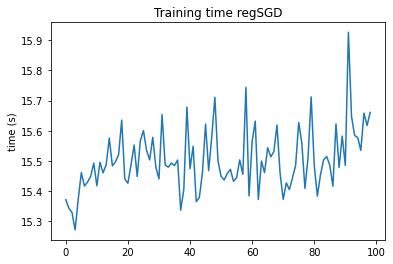

In [0]:
plt.plot(timeRegSGD[1:])
plt.ylabel('time (s)')
plt.title('Training time regSGD')
plt.show()

In [0]:
print(np.mean(timeRegAdam), np.std(timeRegAdam))

15.869344346523285 0.1598347027624794


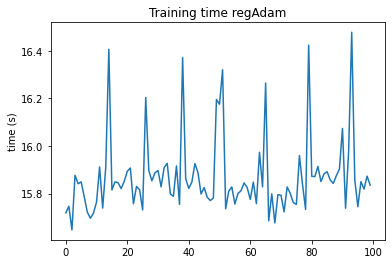

In [0]:
plt.plot(timeRegAdam)
plt.ylabel('time (s)')
plt.title('Training time regAdam')
plt.show()

In [0]:
print(np.mean(timeRegAdaDelta), np.std(timeRegAdaDelta))

16.000487616062163 0.19443074238523608


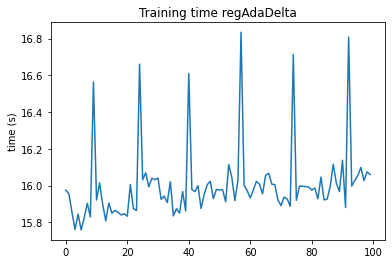

In [0]:
plt.plot(timeRegAdaDelta)
plt.ylabel('time (s)')
plt.title('Training time regAdaDelta')
plt.show()

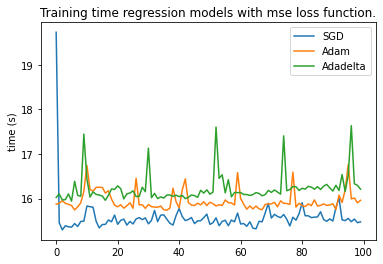

In [0]:
plt.plot(timeRegSGD)
plt.plot(timeRegAdam)
plt.plot(timeRegAdaDelta)
plt.ylabel('time (s)')
plt.title('Training time regression models with mse loss function.')
plt.legend(['SGD', 'Adam', 'Adadelta'])
plt.show()

In [0]:
print(np.mean(timeMCSGD), np.std(timeMCSGD))

15.438258471488952 0.18968114536303193


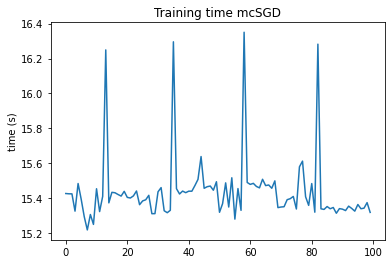

In [0]:
plt.plot(timeMCSGD)
plt.ylabel('time (s)')
plt.title('Training time mcSGD')
plt.show()

In [0]:
print(np.mean(timeMCAdam), np.std(timeMCAdam))

15.809769241809844 0.2684634961912714


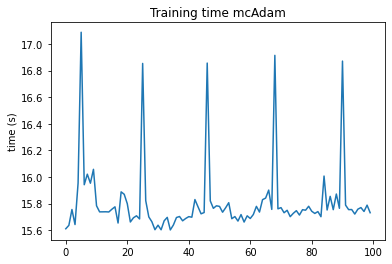

In [0]:
plt.plot(timeMCAdam)
plt.ylabel('time (s)')
plt.title('Training time mcAdam')
plt.show()

In [0]:
print(np.mean(timeMCAdaDelta), np.std(timeMCAdaDelta))

15.995380818843842 0.2832457486458589


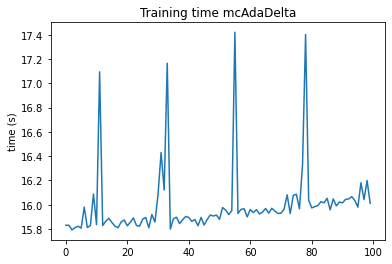

In [0]:
plt.plot(timeMCAdaDelta)
plt.ylabel('time (s)')
plt.title('Training time mcAdaDelta')
plt.show()

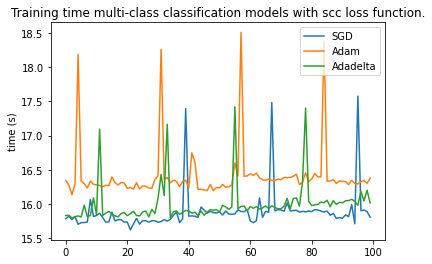

In [0]:
plt.plot(timeMCSGD)
plt.plot(timeMCAdam)
plt.plot(timeMCAdaDelta)
plt.ylabel('time (s)')
plt.title('Training time multi-class classification models with scc loss function.')
plt.legend(['SGD', 'Adam', 'Adadelta'])
plt.show()

In [0]:
plt.plot(timeMCSGD)
plt.plot(timeMCAdam)
plt.plot(timeMCAdaDelta)
plt.ylabel('time (s)')
plt.title('Training time multi-class classification models')
plt.legend(['SGD', 'Adam', 'Adadelta'])
plt.show()

In [0]:
print(np.mean(timeRegSGDcust[1:]), np.std(timeRegSGDcust[1:]))

15.715765803751319 0.15062096095855312


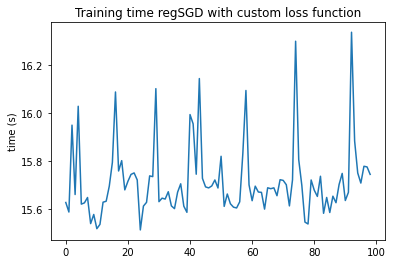

In [0]:
plt.plot(timeRegSGDcust[1:])
plt.ylabel('time (s)')
plt.title('Training time regSGD with custom loss function')
plt.show()

In [0]:
print(np.mean(timeRegAdamcust), np.std(timeRegAdamcust))

16.15764298915863 0.233349940484721


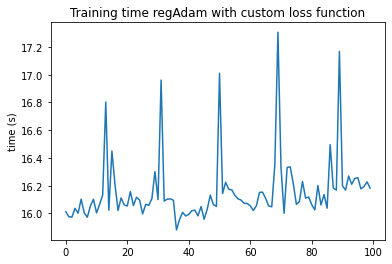

In [0]:
plt.plot(timeRegAdamcust)
plt.ylabel('time (s)')
plt.title('Training time regAdam with custom loss function')
plt.show()

In [0]:
print(np.mean(timeRegAdaDeltacust), np.std(timeRegAdaDeltacust))

16.512689151763915 0.3328546836523872


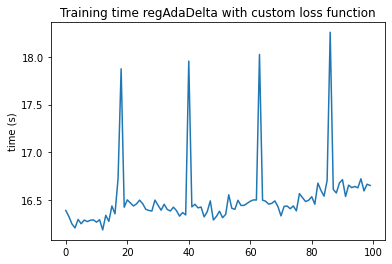

In [0]:
plt.plot(timeRegAdaDeltacust)
plt.ylabel('time (s)')
plt.title('Training time regAdaDelta with custom loss function')
plt.show()

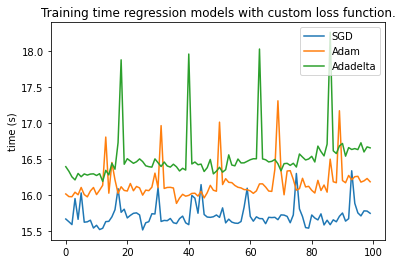

In [0]:
plt.plot(timeRegSGDcust)
plt.plot(timeRegAdamcust)
plt.plot(timeRegAdaDeltacust)
plt.ylabel('time (s)')
plt.title('Training time regression models with custom loss function.')
plt.legend(['SGD', 'Adam', 'Adadelta'])
plt.show()

In [0]:
print(np.mean(timeMCSGDcust), np.std(timeMCSGDcust))

16.620260572433473 0.33138158825304


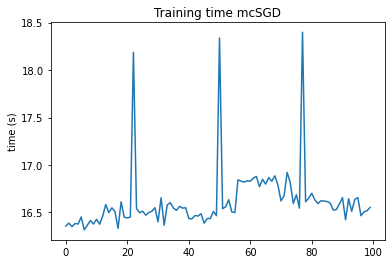

In [0]:
plt.plot(timeMCSGDcust)
plt.ylabel('time (s)')
plt.title('Training time mcSGD')
plt.show()

In [0]:
print(np.mean(timeMCAdamcust), np.std(timeMCAdamcust))

17.243837983608245 0.4959586496601961


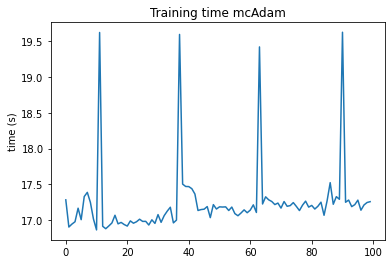

In [0]:
plt.plot(timeMCAdamcust)
plt.ylabel('time (s)')
plt.title('Training time mcAdam')
plt.show()

In [0]:
print(np.mean(timeMCAdaDeltacust), np.std(timeMCAdaDeltacust))

16.09604243993759 1.0169088272345574


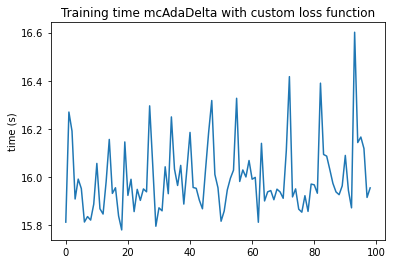

In [0]:
plt.plot(timeMCAdaDeltacust[1:])
plt.ylabel('time (s)')
plt.title('Training time mcAdaDelta with custom loss function')
plt.show()

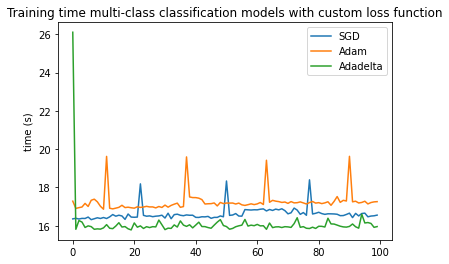

In [0]:
plt.plot(timeMCSGDcust)
plt.plot(timeMCAdamcust)
plt.plot(timeMCAdaDeltacust)
plt.ylabel('time (s)')
plt.title('Training time multi-class classification models with custom loss function')
plt.legend(['SGD', 'Adam', 'Adadelta'])
plt.show()

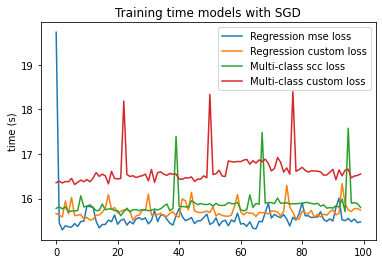

In [0]:
plt.plot(timeRegSGD)
plt.plot(timeRegSGDcust)
plt.plot(timeMCSGD)
plt.plot(timeMCSGDcust)
plt.ylabel('time (s)')
plt.title('Training time models with SGD')
plt.legend(['Regression mse loss', 'Regression custom loss', 'Multi-class scc loss', 'Multi-class custom loss'])
plt.show()

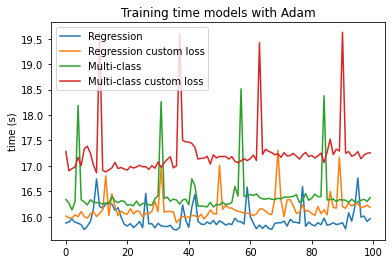

In [0]:
plt.plot(timeRegAdam)
plt.plot(timeRegAdamcust)
plt.plot(timeMCAdam)
plt.plot(timeMCAdamcust)
plt.ylabel('time (s)')
plt.title('Training time models with Adam')
plt.legend(['Regression mse loss', 'Regression custom loss', 'Multi-class scc loss', 'Multi-class custom loss'])
plt.show()

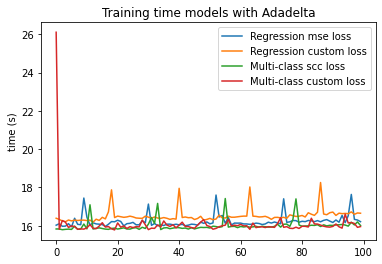

In [0]:
plt.plot(timeRegAdaDelta)
plt.plot(timeRegAdaDeltacust)
plt.plot(timeMCAdaDelta)
plt.plot(timeMCAdaDeltacust)
plt.ylabel('time (s)')
plt.title('Training time models with Adadelta')
plt.legend(['Regression mse loss', 'Regression custom loss', 'Multi-class scc loss', 'Multi-class custom loss'])
plt.show()

# Training process
The models were trained for 500 epochs. The progress of the loss throughout training and final test scores were recorded. 

In [0]:
mcSGD = buildMC(X_train.shape[1:],opt=sgd, losshr=scc, lossmin=scc, metrics=[acc])
mcAdam = buildMC(X_train.shape[1:],opt=adam, losshr=scc, lossmin=scc, metrics=[acc])
mcAdaDelta = buildMC(X_train.shape[1:],opt=adadelta, losshr=scc, lossmin=scc, metrics=[acc])

In [0]:
mcSGD.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 150, 150, 32) 320         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_23[0][0]           
____________________________________________________________________________________________

In [0]:
mcAdam.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 150, 150, 32) 320         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_27[0][0]           
____________________________________________________________________________________________

In [0]:
mcAdaDelta.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 150, 150, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_31[0][0]           
____________________________________________________________________________________________

In [0]:
mcSGDHist, mcSGDScore = do_keras(mcSGD, epochs=500, verbose=1, print_other_stuff=False)
mcAdamHist, mcSGDScore = do_keras(mcAdam, epochs=500, verbose=1, print_other_stuff=False)
mcAdaDeltaHist, mcAdaDeltaScore = do_keras(mcAdaDelta, epochs=500, verbose=1, print_other_stuff=False)

Train on 12960 samples, validate on 1440 samples
Epoch 1/5
12960/12960 [==============================] - 19s 1ms/step - loss: nan - hour_loss: 2.4848 - minute_loss: nan - hour_accuracy: 0.0806 - minute_accuracy: 0.0170 - val_loss: nan - val_hour_loss: 2.4851 - val_minute_loss: nan - val_hour_accuracy: 0.0750 - val_minute_accuracy: 0.0132
Epoch 2/5
12960/12960 [==============================] - 15s 1ms/step - loss: nan - hour_loss: 2.4850 - minute_loss: nan - hour_accuracy: 0.0832 - minute_accuracy: 0.0169 - val_loss: nan - val_hour_loss: 2.4853 - val_minute_loss: nan - val_hour_accuracy: 0.0750 - val_minute_accuracy: 0.0132
Epoch 3/5
12960/12960 [==============================] - 15s 1ms/step - loss: nan - hour_loss: 2.4850 - minute_loss: nan - hour_accuracy: 0.0853 - minute_accuracy: 0.0169 - val_loss: nan - val_hour_loss: 2.4854 - val_minute_loss: nan - val_hour_accuracy: 0.0750 - val_minute_accuracy: 0.0132
Epoch 4/5
12960/12960 [==============================] - 15s 1ms/step - los

In [0]:
np.savetxt('history/mcSGDhrlosstr.csv', np.asarray(mcSGDHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcSGDminlosstr.csv', np.asarray(mcSGDHist.history['minute_loss']), delimiter=',')
np.savetxt('history/mcAdamhrlosstr.csv', np.asarray(mcAdamHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcAdamminlosstr.csv', np.asarray(mcAdamHist.history['minute_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltahrlosstr.csv', np.asarray(mcAdaDeltaHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltaminlosstr.csv', np.asarray(mcAdaDeltaHist.history['minute_loss']), delimiter=',')

np.savetxt('history/mcSGDhrlosstst.csv', np.asarray(mcSGDHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcSGDminlosstst.csv', np.asarray(mcSGDHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/mcAdamhrlosstst.csv', np.asarray(mcAdamHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcAdamminlosstst.csv', np.asarray(mcAdamHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltahrlosstst.csv', np.asarray(mcAdaDeltaHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltaminlosstst.csv', np.asarray(mcAdaDeltaHist.history['val_minute_loss']), delimiter=',')

np.savetxt('history/mcSGDscore.csv', np.asarray(mcSGDScore), delimiter=',')
np.savetxt('history/mcAdamscore.csv', np.asarray(mcAdamScore), delimiter=',')
np.savetxt('history/mcAdaDeltascore.csv', np.asarray(mcAdaDeltaScore), delimiter=',')

In [0]:
mcSGDcustom = buildMC(X_train.shape[1:], opt=sgd, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
mcAdamcustom = buildMC(X_train.shape[1:], opt=adam, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
mcAdaDeltacustom = buildMC(X_train.shape[1:], opt=adadelta, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])

In [0]:
mcSGDcustom.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 150, 150, 32) 320         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_35[0][0]           
____________________________________________________________________________________________

In [0]:
mcAdamcustom.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 150, 150, 32) 320         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_39[0][0]           
___________________________________________________________________________________________

In [0]:
mcAdaDeltacustom.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 150, 150, 32) 320         input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_43[0][0]           
___________________________________________________________________________________________

In [0]:
mcSGDcustHist, mcSGDcustScore = do_keras(mcSGDcustom, epochs=500, verbose=0, print_other_stuff=False)
mcAdamcustHist, mcAdamcustScore = do_keras(mcAdamcustom, epochs=500, verbose=0, print_other_stuff=False)
mcAdaDeltacustHist, mcAdaDeltacustScore = do_keras(mcAdaDeltacustom, epochs=500, verbose=0, print_other_stuff=False)

In [0]:
np.savetxt('history/mcSGDcusthrlosstr.csv', np.asarray(mcSGDcustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcSGDcustminlosstr.csv', np.asarray(mcSGDcustHist.history['minute_loss']), delimiter=',')
np.savetxt('history/mcAdamcusthrlosstr.csv', np.asarray(mcAdamcustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcAdamcustminlosstr.csv', np.asarray(mcAdamcustHist.history['minute_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltacusthrlosstr.csv', np.asarray(mcAdaDeltacustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltacustminlosstr.csv', np.asarray(mcAdaDeltacustHist.history['minute_loss']), delimiter=',')

np.savetxt('history/mcSGDcusthrlosstst.csv', np.asarray(mcSGDcustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcSGDcustminlosstst.csv', np.asarray(mcSGDcustHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/mcAdamcusthrlosstst.csv', np.asarray(mcAdamcustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcAdamcustminlosstst.csv', np.asarray(mcAdamcustHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltacusthrlosstst.csv', np.asarray(mcAdaDeltacustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/mcAdaDeltacustminlosstst.csv', np.asarray(mcAdaDeltacustHist.history['val_minute_loss']), delimiter=',')

np.savetxt('history/mcSGDcustscore.csv', np.asarray(mcSGDcustScore), delimiter=',')
np.savetxt('history/mcAdamcustscore.csv', np.asarray(mcAdamcustScore), delimiter=',')
np.savetxt('history/mcAdaDeltacustscore.csv', np.asarray(mcAdaDeltacustScore), delimiter=',')

In [0]:
regSGD = buildReg(X_train.shape[1:],opt=sgd, losshr=mse, lossmin=mse, metrics=[mse])
regAdam = buildReg(X_train.shape[1:],opt=adam, losshr=mse, lossmin=mse, metrics=[mse])
regAdaDelta = buildReg(X_train.shape[1:],opt=adadelta, losshr=mse, lossmin=mse, metrics=[mse])

In [0]:
regSGD.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 150, 150, 32) 320         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_47 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_47[0][0]           
___________________________________________________________________________________________

In [0]:
regAdam.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 150, 150, 32) 320         input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_51 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_51[0][0]           
___________________________________________________________________________________________

In [0]:
regAdaDelta.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 150, 150, 32) 320         input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_55[0][0]           
___________________________________________________________________________________________

In [0]:
regSGDHist, regSGDScore = do_keras(regSGD, epochs=500, verbose=1, y_train=y_train/60, y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)
regAdamHist, regSGDScore = do_keras(regAdam, epochs=500, verbose=1, y_train=y_train/60,y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)
regAdaDeltaHist, regAdaDeltaScore = do_keras(regAdaDelta, epochs=500, verbose=1, y_train=y_train/60,y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)

Train on 12960 samples, validate on 1440 samples
Epoch 1/5
12960/12960 [==============================] - 15s 1ms/step - loss: 0.1105 - hour_loss: 0.0092 - minute_loss: 0.1012 - hour_mse: 0.0092 - minute_mse: 0.1013 - val_loss: 0.1180 - val_hour_loss: 0.0044 - val_minute_loss: 0.1133 - val_hour_mse: 0.0044 - val_minute_mse: 0.1136
Epoch 2/5
12960/12960 [==============================] - 15s 1ms/step - loss: 0.0943 - hour_loss: 0.0067 - minute_loss: 0.0876 - hour_mse: 0.0067 - minute_mse: 0.0876 - val_loss: 0.1110 - val_hour_loss: 0.0041 - val_minute_loss: 0.1066 - val_hour_mse: 0.0041 - val_minute_mse: 0.1069
Epoch 3/5
12960/12960 [==============================] - 15s 1ms/step - loss: 0.0929 - hour_loss: 0.0057 - minute_loss: 0.0871 - hour_mse: 0.0057 - minute_mse: 0.0871 - val_loss: 0.1029 - val_hour_loss: 0.0037 - val_minute_loss: 0.0988 - val_hour_mse: 0.0037 - val_minute_mse: 0.0992
Epoch 4/5
12960/12960 [==============================] - 15s 1ms/step - loss: 0.0909 - hour_loss: 0

In [0]:
np.savetxt('history/regSGDhrlosstr.csv', np.asarray(regSGDHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regSGDminlosstr.csv', np.asarray(regSGDHist.history['minute_loss']), delimiter=',')
np.savetxt('history/regAdamhrlosstr.csv', np.asarray(regAdamHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regAdamminlosstr.csv', np.asarray(regAdamHist.history['minute_loss']), delimiter=',')
np.savetxt('history/regAdaDeltahrlosstr.csv', np.asarray(regAdaDeltaHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regAdaDeltaminlosstr.csv', np.asarray(regAdaDeltaHist.history['minute_loss']), delimiter=',')

np.savetxt('history/regSGDhrlosstst.csv', np.asarray(regSGDHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regSGDminlosstst.csv', np.asarray(regSGDHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/regAdamhrlosstst.csv', np.asarray(regAdamHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regAdamminlosstst.csv', np.asarray(regAdamHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/regAdaDeltahrlosstst.csv', np.asarray(regAdaDeltaHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regAdaDeltaminlosstst.csv', np.asarray(regAdaDeltaHist.history['val_minute_loss']), delimiter=',')

In [0]:
regSGDcustom = buildReg(X_train.shape[1:],opt=sgd, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[acc])
regAdamcustom = buildReg(X_train.shape[1:], opt=adam, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[mse])
regAdaDeltacustom = buildReg(X_train.shape[1:], opt=adadelta, losshr=hr_error_loss, lossmin=min_error_loss, metrics=[mse])

In [0]:
regSGDcustom.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 150, 150, 32) 320         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_59 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_59[0][0]           
___________________________________________________________________________________________

In [0]:
regAdamcustom.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 150, 150, 32) 320         input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_63 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_63[0][0]           
___________________________________________________________________________________________

In [0]:
regAdaDeltacustom.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 150, 150, 32) 320         input_18[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_67 (MaxPooling2D) (None, 75, 75, 32)   0           conv2d_68[0][0]                  
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 73, 73, 32)   9248        max_pooling2d_67[0][0]           
___________________________________________________________________________________________

In [0]:
regSGDcustHist, regSGDcustScore = do_keras(regSGDcustom, epochs=500, verbose=0, y_train=y_train/60, y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)
regAdamcustHist, regAdamcustScore = do_keras(regAdamcustom, epochs=500, verbose=0, y_train=y_train/60, y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)
regAdaDeltacustHist, regAdaDeltacustScore = do_keras(regAdaDeltacustom, epochs=500, verbose=0, y_train=y_train/60, y_test=y_test/60, y_val=y_val/60, print_other_stuff=False)

In [0]:
np.savetxt('history/regSGDcusthrlosstr.csv', np.asarray(regSGDcustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regSGDcustminlosstr.csv', np.asarray(regSGDcustHist.history['minute_loss']), delimiter=',')
np.savetxt('history/regAdamcusthrlosstr.csv', np.asarray(regAdamcustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regAdamcustminlosstr.csv', np.asarray(regAdamcustHist.history['minute_loss']), delimiter=',')
np.savetxt('history/regAdaDeltacusthrlosstr.csv', np.asarray(regAdaDeltacustHist.history['hour_loss']), delimiter=',')
np.savetxt('history/regAdaDeltacustminlosstr.csv', np.asarray(regAdaDeltacustHist.history['minute_loss']), delimiter=',')

np.savetxt('history/regSGDcusthrlosstst.csv', np.asarray(regSGDcustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regSGDcustminlosstst.csv', np.asarray(regSGDcustHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/regAdamcusthrlosstst.csv', np.asarray(regAdamcustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regAdamcustminlosstst.csv', np.asarray(regAdamcustHist.history['val_minute_loss']), delimiter=',')
np.savetxt('history/regAdaDeltacusthrlosstst.csv', np.asarray(regAdaDeltacustHist.history['val_hour_loss']), delimiter=',')
np.savetxt('history/regAdaDeltacustminlosstst.csv', np.asarray(regAdaDeltacustHist.history['val_minute_loss']), delimiter=',')

np.savetxt('history/regSGDcustscore.csv', np.asarray(regSGDcustScore), delimiter=',')
np.savetxt('history/regAdamcustscore.csv', np.asarray(regAdamcustScore), delimiter=',')
np.savetxt('history/regAdaDeltacustscore.csv', np.asarray(regAdaDeltacustScore), delimiter=',')

In [0]:
mcSGDhrlosstr = np.loadtxt(open("history/mcSGDhrlosstr.csv"), delimiter=",")
mcSGDminlosstr = np.loadtxt(open("history/mcSGDminlosstr.csv"), delimiter=",")
mcAdamhrlosstr = np.loadtxt(open("history/mcAdamhrlosstr.csv"), delimiter=",")
mcAdamminlosstr = np.loadtxt(open("history/mcAdamminlosstr.csv"), delimiter=",")
mcAdaDeltahrlosstr = np.loadtxt(open("history/mcAdaDeltahrlosstr.csv"), delimiter=",")
mcAdaDeltaminlosstr = np.loadtxt(open("history/mcAdaDeltaminlosstr.csv"), delimiter=",")

mcSGDhrlosstst = np.loadtxt(open("history/mcSGDhrlosstst.csv"), delimiter=",")
mcSGDminlosstst = np.loadtxt(open("history/mcSGDminlosstst.csv"), delimiter=",")
mcAdamhrlosstst = np.loadtxt(open("history/mcAdamhrlosstst.csv"), delimiter=",")
mcAdamminlosstst = np.loadtxt(open("history/mcAdamminlosstst.csv"), delimiter=",")
mcAdaDeltahrlosstst = np.loadtxt(open("history/mcAdaDeltahrlosstst.csv"), delimiter=",")
mcAdaDeltaminlosstst = np.loadtxt(open("history/mcAdaDeltaminlosstst.csv"), delimiter=",")

mcSGDscore = np.loadtxt(open("history/mcSGDscore.csv"), delimiter=",")
mcAdamscore = np.loadtxt(open("history/mcAdamscore.csv"), delimiter=",")
mcAdaDeltascore = np.loadtxt(open("history/mcAdaDeltascore.csv"), delimiter=",")

mcSGDcusthrlosstr = np.loadtxt(open("history/mcSGDcusthrlosstr.csv"), delimiter=",")
mcSGDcustminlosstr = np.loadtxt(open("history/mcSGDcustminlosstr.csv"), delimiter=",")
mcAdamcusthrlosstr = np.loadtxt(open("history/mcAdamcusthrlosstr.csv"), delimiter=",")
mcAdamcustminlosstr = np.loadtxt(open("history/mcAdamcustminlosstr.csv"), delimiter=",")
mcAdaDeltacusthrlosstr = np.loadtxt(open("history/mcAdaDeltacusthrlosstr.csv"), delimiter=",")
mcAdaDeltacustminlosstr = np.loadtxt(open("history/mcAdaDeltacustminlosstr.csv"), delimiter=",")

mcSGDcusthrlosstst = np.loadtxt(open("history/mcSGDcusthrlosstst.csv"), delimiter=",")
mcSGDcustminlosstst = np.loadtxt(open("history/mcSGDcustminlosstst.csv"), delimiter=",")
mcAdamcusthrlosstst = np.loadtxt(open("history/mcAdamcusthrlosstst.csv"), delimiter=",")
mcAdamcustminlosstst = np.loadtxt(open("history/mcAdamcustminlosstst.csv"), delimiter=",")
mcAdaDeltacusthrlosstst = np.loadtxt(open("history/mcAdaDeltacusthrlosstst.csv"), delimiter=",")
mcAdaDeltacustminlosstst = np.loadtxt(open("history/mcAdaDeltacustminlosstst.csv"), delimiter=",")

mcSGDcustscore = np.loadtxt(open("history/mcSGDcustscore.csv"), delimiter=",")
mcAdamcustscore = np.loadtxt(open("history/mcAdamcustscore.csv"), delimiter=",")
mcAdaDeltacustscore = np.loadtxt(open("history/mcAdaDeltacustscore.csv"), delimiter=",")


regSGDhrlosstr = np.loadtxt(open("history/regSGDhrlosstr.csv"), delimiter=",")
regSGDminlosstr = np.loadtxt(open("history/regSGDminlosstr.csv"), delimiter=",")
regAdamhrlosstr = np.loadtxt(open("history/regAdamhrlosstr.csv"), delimiter=",")
regAdamminlosstr = np.loadtxt(open("history/regAdamminlosstr.csv"), delimiter=",")
regAdaDeltahrlosstr = np.loadtxt(open("history/regAdaDeltahrlosstr.csv"), delimiter=",")
regAdaDeltaminlosstr = np.loadtxt(open("history/regAdaDeltaminlosstr.csv"), delimiter=",")

regSGDhrlosstst = np.loadtxt(open("history/regSGDhrlosstst.csv"), delimiter=",")
regSGDminlosstst = np.loadtxt(open("history/regSGDminlosstst.csv"), delimiter=",")
regAdamhrlosstst = np.loadtxt(open("history/regAdamhrlosstst.csv"), delimiter=",")
regAdamminlosstst = np.loadtxt(open("history/regAdamminlosstst.csv"), delimiter=",")
regAdaDeltahrlosstst = np.loadtxt(open("history/regAdaDeltahrlosstst.csv"), delimiter=",")
regAdaDeltaminlosstst = np.loadtxt(open("history/regAdaDeltaminlosstst.csv"), delimiter=",")

regSGDscore = np.loadtxt(open("history/regSGDscore.csv"), delimiter=",")
regAdamscore = np.loadtxt(open("history/regAdamscore.csv"), delimiter=",")
regAdaDeltascore = np.loadtxt(open("history/regAdaDeltascore.csv"), delimiter=",")

regSGDcusthrlosstr = np.loadtxt(open("history/regSGDcusthrlosstr.csv"), delimiter=",")
regSGDcustminlosstr = np.loadtxt(open("history/regSGDcustminlosstr.csv"), delimiter=",")
regAdamcusthrlosstr = np.loadtxt(open("history/regAdamcusthrlosstr.csv"), delimiter=",")
regAdamcustminlosstr = np.loadtxt(open("history/regAdamcustminlosstr.csv"), delimiter=",")
regAdaDeltacusthrlosstr = np.loadtxt(open("history/regAdaDeltacusthrlosstr.csv"), delimiter=",")
regAdaDeltacustminlosstr = np.loadtxt(open("history/regAdaDeltacustminlosstr.csv"), delimiter=",")

regSGDcusthrlosstst = np.loadtxt(open("history/regSGDcusthrlosstst.csv"), delimiter=",")
regSGDcustminlosstst = np.loadtxt(open("history/regSGDcustminlosstst.csv"), delimiter=",")
regAdamcusthrlosstst = np.loadtxt(open("history/regAdamcusthrlosstst.csv"), delimiter=",")
regAdamcustminlosstst = np.loadtxt(open("history/regAdamcustminlosstst.csv"), delimiter=",")
regAdaDeltacusthrlosstst = np.loadtxt(open("history/regAdaDeltacusthrlosstst.csv"), delimiter=",")
regAdaDeltacustminlosstst = np.loadtxt(open("history/regAdaDeltacustminlosstst.csv"), delimiter=",")

regSGDcustscore = np.loadtxt(open("history/regSGDcustscore.csv"), delimiter=",")
regAdamcustscore = np.loadtxt(open("history/regAdamcustscore.csv"), delimiter=",")
regAdaDeltacustscore = np.loadtxt(open("history/regAdaDeltacustscore.csv"), delimiter=",")

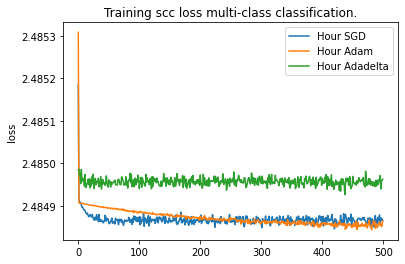

In [0]:
plt.plot(mcSGDhrlosstr)
# plt.plot(mcSGDminlosstr)
plt.plot(mcAdamhrlosstr)
# plt.plot(mcAdamminlosstr)
plt.plot(mcAdaDeltahrlosstr)
# plt.plot(mcAdaDeltaminlosstr)
plt.ylabel('loss')
plt.title('Training scc loss multi-class classification.')
# plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.legend(['Hour SGD', 'Hour Adam', 'Hour Adadelta'])

plt.show()

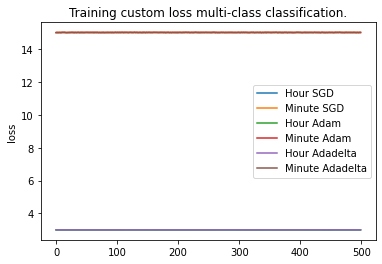

In [0]:
plt.plot(mcSGDcusthrlosstr)
plt.plot(mcSGDcustminlosstr)
plt.plot(mcAdamcusthrlosstr)
plt.plot(mcAdamcustminlosstr)
plt.plot(mcAdaDeltacusthrlosstr)
plt.plot(mcAdaDeltacustminlosstr)
plt.ylabel('loss')
plt.title('Training custom loss multi-class classification.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

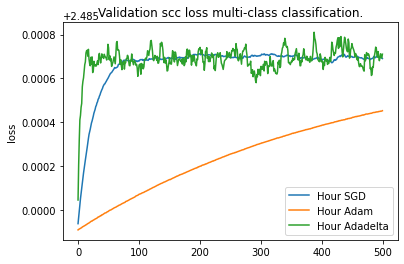

In [0]:
plt.plot(mcSGDhrlosstst)
# plt.plot(mcSGDminlosstst)
plt.plot(mcAdamhrlosstst)
# plt.plot(mcAdamminlosstst)
plt.plot(mcAdaDeltahrlosstst)
# plt.plot(mcAdaDeltaminlosstst)
plt.ylabel('loss')
plt.title('Validation scc loss multi-class classification.')
# plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.legend(['Hour SGD', 'Hour Adam', 'Hour Adadelta'])

plt.show()

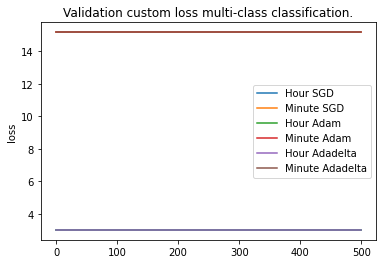

In [0]:
plt.plot(mcSGDcusthrlosstst)
plt.plot(mcSGDcustminlosstst)
plt.plot(mcAdamcusthrlosstst)
plt.plot(mcAdamcustminlosstst)
plt.plot(mcAdaDeltacusthrlosstst)
plt.plot(mcAdaDeltacustminlosstst)
plt.ylabel('loss')
plt.title('Validation custom loss multi-class classification.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

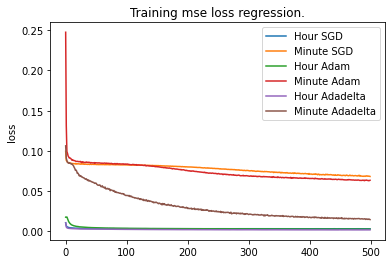

In [0]:
plt.plot(regSGDhrlosstr)
plt.plot(regSGDminlosstr)
plt.plot(regAdamhrlosstr)
plt.plot(regAdamminlosstr)
plt.plot(regAdaDeltahrlosstr)
plt.plot(regAdaDeltaminlosstr)
plt.ylabel('loss')
plt.title('Training mse loss regression.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

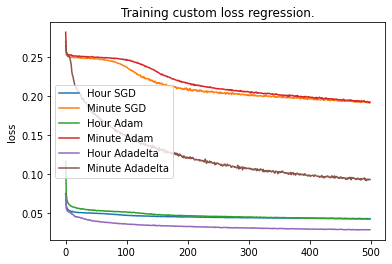

In [0]:
plt.plot(regSGDcusthrlosstr)
plt.plot(regSGDcustminlosstr)
plt.plot(regAdamcusthrlosstr)
plt.plot(regAdamcustminlosstr)
plt.plot(regAdaDeltacusthrlosstr)
plt.plot(regAdaDeltacustminlosstr)
plt.ylabel('loss')
plt.title('Training custom loss regression.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

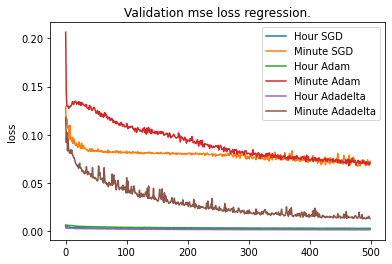

In [0]:
plt.plot(regSGDhrlosstst)
plt.plot(regSGDminlosstst)
plt.plot(regAdamhrlosstst)
plt.plot(regAdamminlosstst)
plt.plot(regAdaDeltahrlosstst)
plt.plot(regAdaDeltaminlosstst)
plt.ylabel('loss')
plt.title('Validation mse loss regression.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

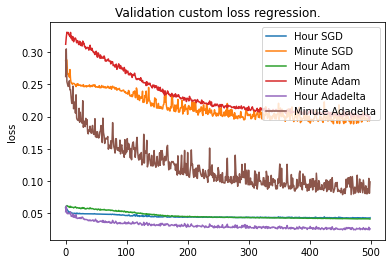

In [0]:
plt.plot(regSGDcusthrlosstst)
plt.plot(regSGDcustminlosstst)
plt.plot(regAdamcusthrlosstst)
plt.plot(regAdamcustminlosstst)
plt.plot(regAdaDeltacusthrlosstst)
plt.plot(regAdaDeltacustminlosstst)
plt.ylabel('loss')
plt.title('Validation custom loss regression.')
plt.legend(['Hour SGD', 'Minute SGD', 'Hour Adam', 'Minute Adam', 'Hour Adadelta', 'Minute Adadelta'])
plt.show()

In [0]:
mcSGD.metrics_names

['loss', 'hour_loss', 'minute_loss', 'hour_accuracy', 'minute_accuracy']

In [0]:
mcSGDscore

array([       nan, 2.48511553,        nan, 0.07972223, 0.01722222])

In [0]:
mcAdamscore

array([       nan, 2.48504162,        nan, 0.07972223, 0.01722222])

In [0]:
mcAdaDeltascore

array([       nan, 2.48511553,        nan, 0.07972223, 0.01722222])

In [0]:
mcSGDcustscore

array([17.86946884,  3.01889801, 14.85902309,  0.        ,  0.        ])

In [0]:
mcAdamcustscore

array([17.86946882,  3.01889825, 14.85902309,  0.        ,  0.        ])

In [0]:
mcAdaDeltacustscore

array([17.86946876,  3.01889801, 14.85902309,  0.07333333,  0.        ])

In [0]:
regSGDscore

array([0.0769362 , 0.00303044, 0.07377978, 0.00302184, 0.07391435])

In [0]:
regAdamscore

array([0.0755056 , 0.0028589 , 0.07250359, 0.00284844, 0.07265715])

In [0]:
regAdaDeltascore

array([0.01579574, 0.00158741, 0.01418784, 0.00158566, 0.01421008])

In [0]:
regSGDcustscore

array([0.24352531, 0.04231815, 0.20094559, 0.0825    , 0.01722222])

In [0]:
regAdamcustscore

array([0.24241056, 0.04096944, 0.2012677 , 0.00258979, 0.06842024])

In [0]:
regAdaDeltacustscore

array([0.12616363, 0.0250553 , 0.10096175, 0.00116179, 0.02161874])